In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shrishivamkumar","key":"4f54632aba7c42cf8f9051b4bf1a09df"}'}

In [5]:
!mkdir ~/.CVProject
!cp kaggle.json ~/.CVProject/
! chmod 600 ~/.CVProject/kaggle.json
import os
# Set the path to your Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.CVProject'
# ! kaggle competitions download -c 'paultimothymooney/chest-xray-pneumonia'
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip \*.zip && rm*.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0451-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0452-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0453-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0453-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0455-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0456-0001.jpeg  
  inflating: chest_xray/train/NO

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# **Create the data transforms **

with RGB conversion and Augmentation for training data using random rotation and auto contrast to improve overfitting issue.

In [6]:
import torchvision.transforms.functional as F
from torchvision import transforms

image_size = (224,224)

# Define a transform to convert images to RGB
convert_to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))

convert_to_grayscale = transforms.Lambda(lambda image: image.convert('L'))

train_transform=transforms.Compose([
    convert_to_rgb,
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(p=0.5),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    #Normalization values for grayscale
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #Normalization values for RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

transform=transforms.Compose([
    convert_to_rgb,
    transforms.Resize(image_size),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# **Setting the hyperparameters**

In [7]:
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

# **Loading Data from Kaggle folders**

In [9]:
#Load and view images and labels
import torch
import torchvision
from torchvision.transforms import ToTensor
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
import random

train_ds = torchvision.datasets.ImageFolder('/content/chest_xray/chest_xray/train', transform=train_transform)
valid_ds = torchvision.datasets.ImageFolder('/content/chest_xray/chest_xray/val', transform=transform)
test_ds = torchvision.datasets.ImageFolder('/content/chest_xray/chest_xray/test', transform=transform)

print(train_ds.classes)
print(len(train_ds))
image, label = train_ds[0]
#image is channel,
print(image.shape)
print(train_ds.classes[label])


['NORMAL', 'PNEUMONIA']
5216
torch.Size([3, 224, 224])
NORMAL


In [10]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Number of val samples: ", len(valid_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


Number of train samples:  5216
Number of test samples:  624
Number of val samples:  16
Detected Classes are:  {'NORMAL': 0, 'PNEUMONIA': 1}


# **Show 3 images of normal Chest x-ray and 6 images of pneumonia x-ray**

In [11]:
def show_examples(train_data_loader, max_normal = 3):

    plt.figure(figsize=(10, 10))
    cnt = 0

    for batch in train_data_loader:
        images, targets = batch
        i = 0
        for i in range(len(images)):
            if targets[i] == 0 and cnt < max_normal:
                ax = plt.subplot(max_normal, max_normal, cnt + 1)
                plt.imshow(images[i].permute(1, 2, 0))
                plt.title(train_ds.classes[targets[i]])
                cnt += 1
            elif targets[i] == 1 and ((max_normal - 1) < cnt < (max_normal * 3)):
                ax = plt.subplot(max_normal, max_normal, cnt + 1)
                plt.imshow(images[i].permute(1, 2, 0))
                plt.title(train_ds.classes[targets[i]])
                cnt += 1
        if cnt == (max_normal * 3):
            break


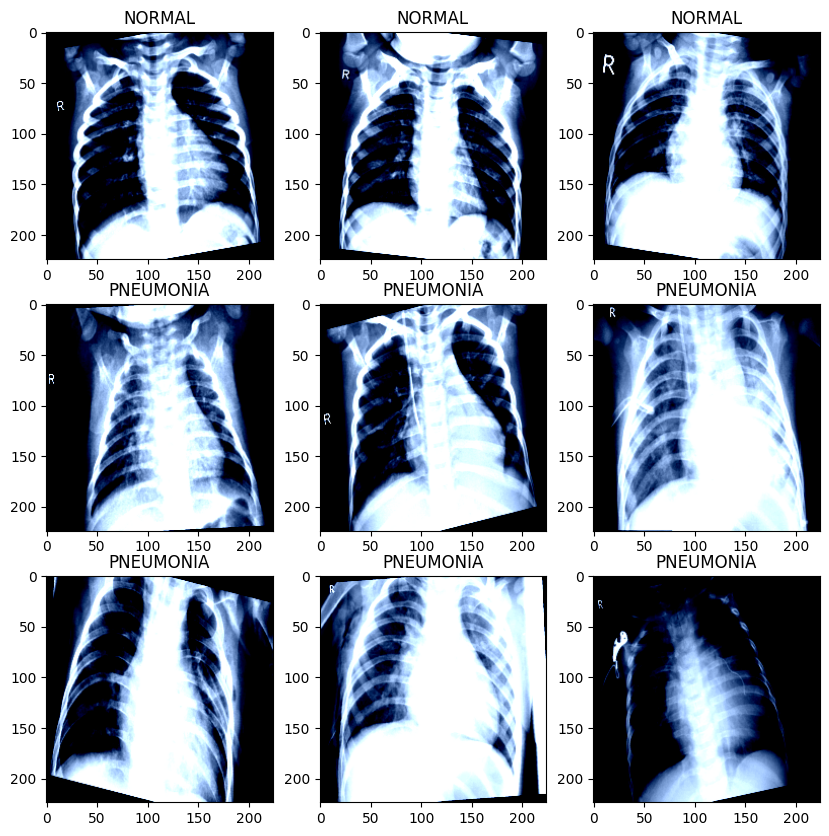

In [12]:
show_examples(train_loader)

# **Load the pretrained Model and define ViTForImageClassification class**

VIT model vit-base-patch16-224-in21k as the base model.
pretrained model used 'google/vit-base-patch16-224-in21k' mentioned in the code is a Vision Transformer model trained by Google. The model is trained on an image dataset with 224x224 resolution images and 21k classes.

The original Vision Transformer paper by Dosovitskiy et al., and resources on the Hugging Face Model Hub, which provides a variety of pretrained models including Vision Transformers.

Sources:

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv preprint arXiv:2010.11929. [Link](https://arxiv.org/abs/2010.11929)
Hugging Face Model Hub. [Link](https://huggingface.co/google/vit-base-patch16-224-in21k)

In [13]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=2):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        #self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        #output = self.dropout(outputs.last_hidden_state[:,0])
        output = outputs.last_hidden_state[:,0]
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

ModuleNotFoundError: ignored

In [ ]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer with L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
'''
# Cross Entropy Loss with L1 regularization
l1_lambda = 0.01
l1_norm = sum(p.abs().sum() for p in model.parameters())
loss_func = nn.CrossEntropyLoss() + l1_lambda * l1_norm
'''
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# ****Running fine-tuning training**

on the pretrained model against the chest x-ray dataset with steps of batch 16 on entire training dataset for each epoch.
'patch16': This indicates that the input images are divided into patches of size 16x16 pixels.
'224': This is the size of the input images, which are 224x224 pixels.
'in21k': This indicates that the model was initially trained on a dataset containing 21,000 different classes.
The feature extractor is responsible for preprocessing the images so that they can be inputted into the Vision Transformer model. This includes resizing the images to the required dimensions (224x224 pixels in this case), normalizing the pixel values, and dividing the images into patches of 16x16 pixels, which can be considered as the "tokens" for the Vision Transformer.

Sources:

Hugging Face Transformers Documentation: [https://huggingface.co/transformers/model_doc/vit.html](https://huggingface.co/transformers/model_doc/vit.html)


In [14]:

print("train_loader length: " + str(len(train_loader)))
print("sanity check: " + str(len(train_ds)/BATCH_SIZE))

trainingEpoch_loss = []
validationEpoch_loss = []
trainingEpoch_acc = []
validationEpoch_acc = []

#n_total_steps = len(train_ds)
n_total_steps = len(train_loader)
print("Total steps: " + str(n_total_steps))
# Train the model
for epoch in range(EPOCHS):
    step_loss = []
    train_acc = []
    validationStep_loss = []
    test_acc = []
    for step, (x, y) in enumerate(train_loader):
        # Change input array into list with each batch being one element
        x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
        # Remove unnecessary dimension
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)

        # Apply feature extractor, stack back into 1 tensor and then
        #convert to tensor
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))

        # Send to GPU if available
        x, y  = x.to(device), y.to(device)
        #b_x = Variable(x)   # batch x (image)
        #b_y = Variable(y)   # batch y (target)
        # Feed through model
        #output, loss = model(b_x, None)
        output, loss = model(x, None)
        # Calculate loss
        if loss is None:
            #loss = loss_func(output, b_y)
            loss = loss_func(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_outputargmax = output.argmax(1)
        # Because we passed in None for the targets to the model
        #training, the loss is a tensor, so we need to use .item() to get
        #single float value
        train_accuracy = (train_outputargmax == y).sum().item() / BATCH_SIZE
        train_acc.append(train_accuracy)
        step_loss.append(loss.item())
        #if (step+1) % 1 == 0:
        #    print (f'training Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        #    print(f'training accuracy {train_accuracy}')

        if step % 50 == 0:
            # Get the next batch for testing purposes
            test = next(iter(test_loader))
            test_x = test[0]
            # Reshape and get feature matrices as needed
            test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
            for index, array in enumerate(test_x):
                test_x[index] = np.squeeze(array)
            test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
            # Send to appropirate computing device
            test_x = test_x.to(device)
            test_y = test[1].to(device)
            # Get output (+ respective class) and compare to target
            # passing in y targets will give a single float value from
            # model, so we do not need the .item() call when appending loss
            test_output, validation_loss = model(test_x, test_y)
            test_outputargmax = test_output.argmax(1)

            # Calculate Accuracy
            accuracy = (test_outputargmax == test_y).sum().item() / BATCH_SIZE
            print('Epoch: ', epoch, '| test loss: %.4f' % validation_loss, '| test accuracy: %.2f' % accuracy)
            test_acc.append(accuracy)
            validationStep_loss.append(validation_loss)
            print (f'training Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            print(f'training accuracy {train_accuracy}')


    validationEpoch_loss.append(np.mean(validationStep_loss))
    trainingEpoch_loss.append(np.mean(step_loss))
    validationEpoch_acc.append(np.mean(test_acc))
    trainingEpoch_acc.append(np.mean(train_acc))

train_loader length: 326
sanity check: 326.0
Total steps: 326


NameError: ignored

# **Graph the loss and accuracy of the training and test sets**

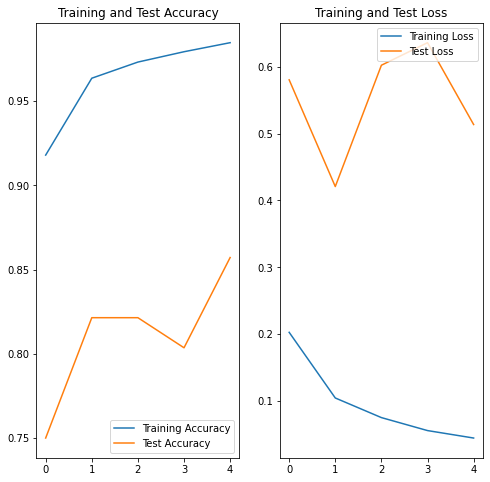

In [ ]:
acc = trainingEpoch_acc
test_acc = validationEpoch_acc

loss = trainingEpoch_loss
test_loss = validationEpoch_loss

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

# **Predict Chest x-ray from the validation set**

Predicted values: tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
targeted values: tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')


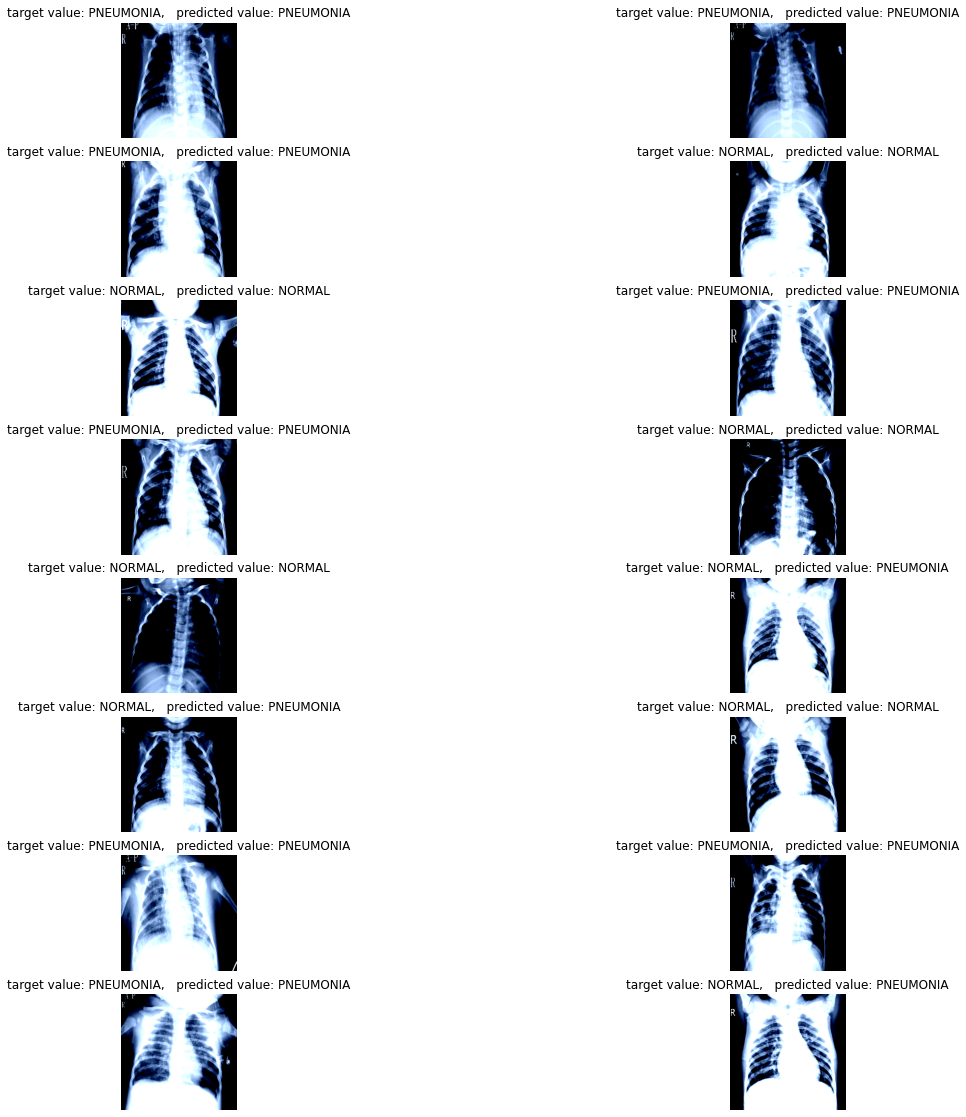

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 16
eval_loader  = test_loader  = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

plt.figure(figsize=(20, 20))

# Disable grad
with torch.no_grad():
    for step, (x, y) in enumerate(eval_loader):
        eval = next(iter(eval_loader))
        eval_x = eval[0]
        # Reshape and get feature matrices as needed
        eval_x = np.split(np.squeeze(np.array(eval_x)), BATCH_SIZE)
        for index, array in enumerate(eval_x):
            eval_x[index] = np.squeeze(array)
        eval_x = torch.tensor(np.stack(feature_extractor(eval_x)['pixel_values'], axis=0))
        # Send to appropirate computing device
        eval_x = eval_x.to(device)
        eval_y = eval[1].to(device)
        # Get output (+ respective class) and compare to target
        # passing in y targets will give a single float value from
        # model, so we do not need the .item() call when appending loss
        eval_output, eval_loss = model(eval_x, eval_y)
        eval_outputargmax = eval_output.argmax(1)

        print(f"Predicted values: {eval_outputargmax}")
        print(f"targeted values: {eval_y}")
        #value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(eval_outputargmax)]
        #value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(eval_y)]

        images, targets = eval
        i = 0
        cnt = 0
        for i in range(len(images)):
            ax = plt.subplot(int(EVAL_BATCH/2), int(EVAL_BATCH/8), cnt + 1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"target value: {train_ds.classes[targets[i]]},   predicted value: {train_ds.classes[eval_outputargmax[i]]}")
            ax.set_axis_off()
            cnt += 1



# **Save the fine-tuned model and reload it again to run prediction on unseen chest xray**

In [ ]:
torch.save(model, '/kaggle/working/model.pt')

In [ ]:
MODEL_PATH = '/kaggle/working/model.pt'
model = torch.load(MODEL_PATH)

tensor([1], device='cuda:0')


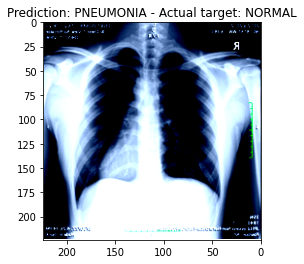

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

singleDs = torchvision.datasets.ImageFolder('/kaggle/input/myprivatedataset/', transform=transform)
EVAL_BATCH = 1
eval_loader  = data.DataLoader(singleDs, batch_size=EVAL_BATCH, shuffle=True, num_workers=2)

# Disable grad
with torch.no_grad():
    inputs, targets = next(iter(eval_loader))
    # Reshape and get feature matrices as needed

    #inputs = inputs.permute(1,2,0)
    # Save original Input
    originalInput = inputs
    eval_x = inputs[0]
    for index, array in enumerate(eval_x):
        eval_x[index] = np.squeeze(array)
    eval_x = torch.tensor(np.stack(feature_extractor(eval_x)['pixel_values'], axis=0))
    # Send to appropriate computing device
    eval_x = eval_x.to(device)
    targets = targets.to(device)

    # Generate prediction
    # if we do not pass None for the targets, the
    # loss will be a float value, so we do not need to use .item()
    prediction, loss = model(eval_x, targets)

    # Predicted class value using argmax
    predicted_class = prediction.argmax(1)
    #predicted_class = np.argmax(prediction.cpu())

    print(predicted_class)
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(targets)]

    # Show result
    inputs = originalInput[0].permute(1, 2, 0)
    plt.imshow(inputs)
    plt.xlim(224,0)
    plt.ylim(224,0)
    plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    plt.show()
